# **Pokemón Diffusion Overfitting<a id="top"></a>**

<i><small>**Alumno:** Alejandro Pequeño Lizcano</small></i></div>

---

**Objetivo:** 
Este notebook tiene como objetivo forzar el overfitting de un modelo de difusión para poder analizar su comportamiento y entender cómo se comporta en un entorno controlado y poder arreglar posibles fallos en el código.

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)
    - [1.1. Predataset](##-1.1.-Predataset)
    - [1.2. Dataset](##-1.2.-Dataset)

- [2. Modelo de Difusión](#-2.-Modelo-de-Difusión)
    - [2.1. Forward Diffusion](##-2.1.-Forward-Diffusion)
    - [2.2. Reverse Diffusion](##-2.2.-Reverse-Diffusion)
    - [2.3. Train Diffusion Model](##-2.3.-Train-Diffusion-Model)

---

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import libraries for data preprocessing
import numpy as np
import pandas as pd
from tqdm.auto import trange, tqdm  # progress bar

# Import libraries for data and folder manipulation
import random
import os
import json

# Import libraries from tensorflow for building the model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers

# Import necessary libraries
# =====================================================================
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf

# Import src code
from src.data.create_dataset import *
from src.model.build_unet import build_unet
from src.utils.utils import *
from src.visualization import visualize

# from src.model.diffusion_model import *
from src.model.overfitting_test import *

/home/pqlza/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-27 10:48:08.109346: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-27 10:48:08.138300: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-27 10:48:09.069087: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 10:48:09.072911: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 10:48:09.073038: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 32
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 32
EPOCHS = 100
T = 150
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

2024-04-27 10:48:09.083394: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 10:48:09.083563: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 10:48:09.083674: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# load df and data_dict
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

with open(f"{DATA_PATH}/interim/pokemon_dict_dataset.json", "r") as f:
    data_dict = json.load(f)

from src.data.path_loader import PathLoader as pl

loader = pl(
    load_pattern=f"{DATA_PATH}/raw/sprites/**/front/**/*.png",
)

# Load the paths from the file
image_paths = loader.load_paths()

from src.data.create_dataset import dataset_dict

data_dict = dataset_dict(image_paths=image_paths, df=df)

Loading paths...

- Number of paths loaded: 8143



- The shape of the dataset is: (32, 32, 32, 3) => batch_size: 32, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


2024-04-27 10:48:10.270440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


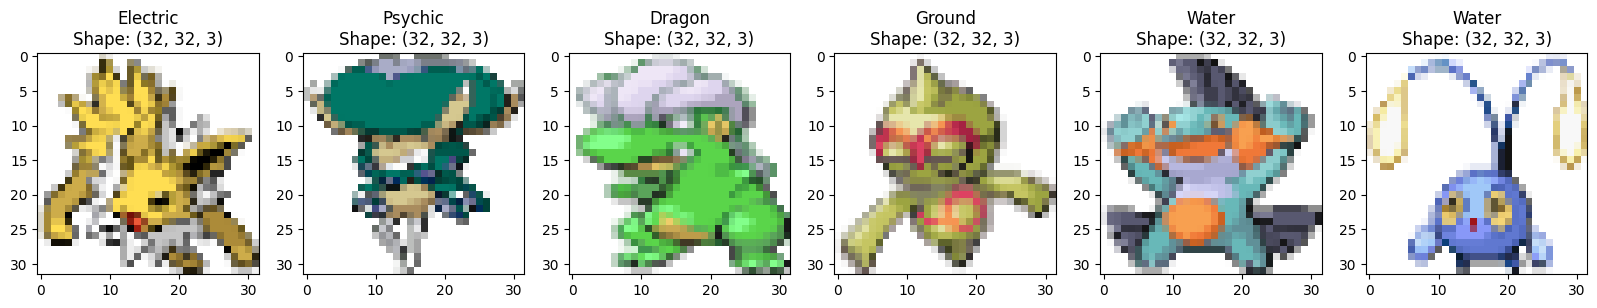

2024-04-27 10:48:10.778933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    df=df,
    dict_dataset=data_dict,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 32, 32, 3)
(32, 18)


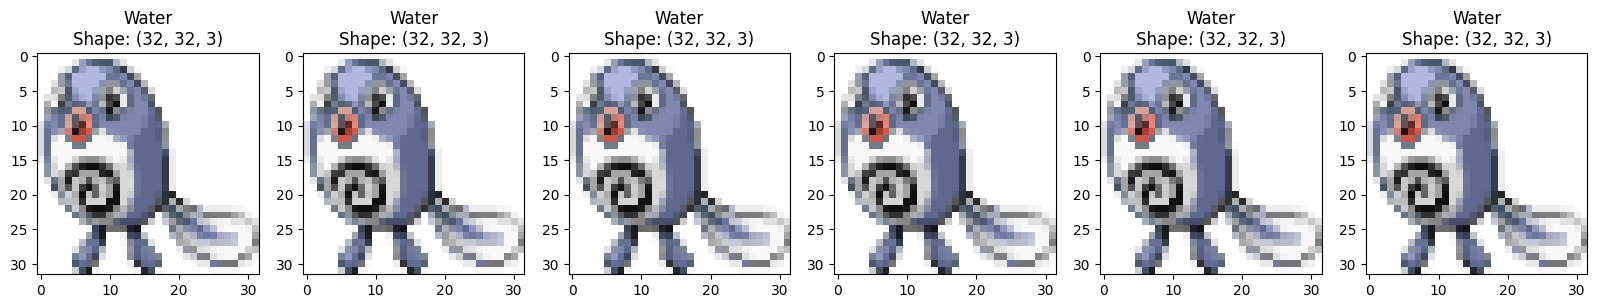

2024-04-27 10:48:11.245576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-27 10:48:11.246456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
# get one batch of the dataset
dataset_example = poke_dataset.take(1)

# get one specific image of the batch
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

# get only one image of the dataset
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

img_example = np.expand_dims(img_example, axis=0)  # expand the image to the batch size
label_example = np.expand_dims(
    label_example, axis=0
)  # expand the label to the batch size

dataset_example = tf.data.Dataset.from_tensor_slices((img_example, label_example))

dataset_example = dataset_example.repeat(512).batch(BATCH_SIZE)

for img, label in dataset_example:
    print(type(img), type(label))
    print(img.shape)
    print(label.shape)
    break

for img, label in dataset_example.take(1):
    label_example = label[0]
    visualize.plot_images_batch(dataset_tf=dataset_example)

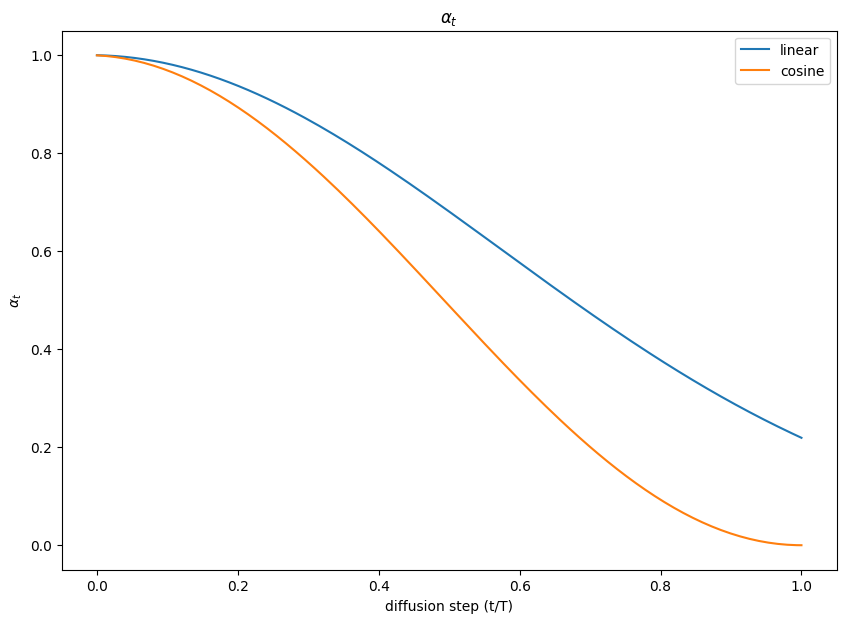

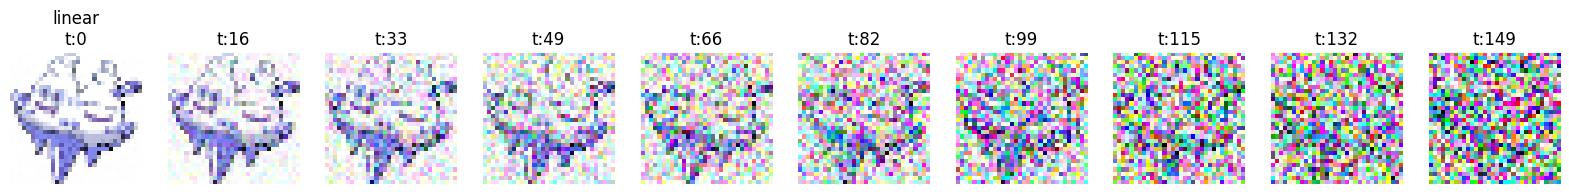

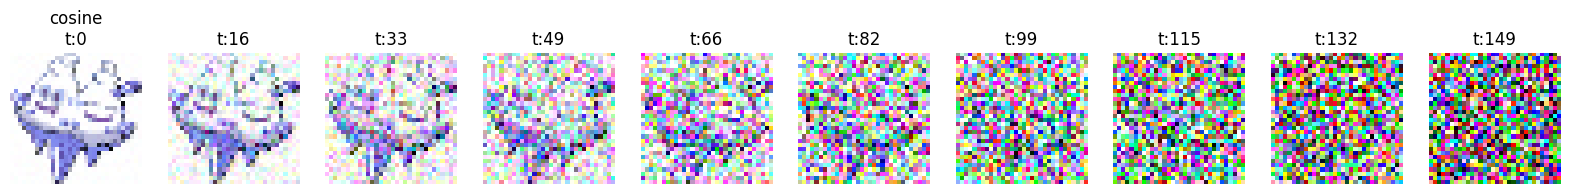

In [7]:
# Plot all the noise levels in the same plot
# =====================================================================
visualize.plot_noise_levels(T, BETA_START, BETA_END, s)

# Plot the forward diffusion function
# =====================================================================
X_train = poke_dataset.map(lambda x, y: x)  # Get the images from the dataset
random_image = next(iter(X_train))[random.randint(0, BATCH_SIZE)]

visualize.plot_forward_diffusion(random_image, "linear", 10, T, BETA_START, BETA_END, s)
visualize.plot_forward_diffusion(random_image, "cosine", 10, T, BETA_START, BETA_END, s)

In [8]:
label_example

<tf.Tensor: shape=(18,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1.], dtype=float32)>

In [9]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

Epoch 1/100


2024-04-27 10:48:13.336148: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - loss: 1.1812
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - loss: 0.8934
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 0.8621
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 0.7687
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step - loss: 0.6224
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - loss: 0.4360
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - loss: 0.4004
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.3026
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - loss: 0.3930
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.3097Epoch 10: Generating samples.
Generating sample 1/1


Sampling sprite: 150it [00:06, 24.53it/s]                         


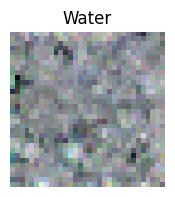

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 661ms/step - loss: 0.2915
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - loss: 0.2754
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.3371
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 0.2385
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - loss: 0.2116
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - loss: 0.2656
Epoch 16/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - loss: 0.2298
Epoch 17/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - loss: 0.1474
Epoch 18/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - loss: 0.1484
Epoch 19/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 0.2493
Epoch 20/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.2483Epoch 20: Generating samples.
Generating sample 1/1


Sampling sprite: 150it [00:05, 26.04it/s]                         


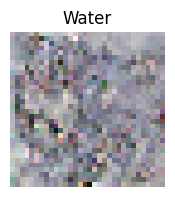

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 627ms/step - loss: 0.2337
Epoch 21/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - loss: 0.1621
Epoch 22/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - loss: 0.2005
Epoch 23/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - loss: 0.1882
Epoch 24/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 0.2324
Epoch 25/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - loss: 0.1844
Epoch 26/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 0.1791
Epoch 27/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 0.1747
Epoch 28/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 0.1427
Epoch 29/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - loss: 0.1768
Epoch 30/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.1385Epoch 30: Generating samples.
Generating sample 1/1


Sampling sprite: 150it [00:06, 24.67it/s]                         


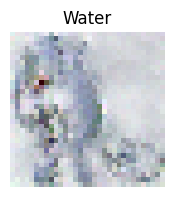

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 673ms/step - loss: 0.1304
Epoch 31/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 0.2090
Epoch 32/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - loss: 0.1075
Epoch 33/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 0.1592
Epoch 34/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - loss: 0.1244
Epoch 35/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - loss: 0.1179
Epoch 36/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - loss: 0.1332
Epoch 37/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 0.2216
Epoch 38/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - loss: 0.2264
Epoch 39/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - loss: 0.2382
Epoch 40/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.1635Epoch 40: Generating samples.
Generating sample 1/1


Sampling sprite: 150it [00:06, 24.39it/s]                         


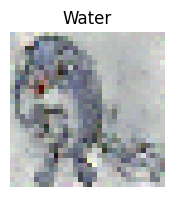

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 670ms/step - loss: 0.1538
Epoch 41/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - loss: 0.1180
Epoch 42/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - loss: 0.0798
Epoch 43/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - loss: 0.1098
Epoch 44/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 0.2308
Epoch 45/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - loss: 0.2163
Epoch 46/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 0.2203
Epoch 47/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - loss: 0.1107
Epoch 48/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 0.1677
Epoch 49/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - loss: 0.0752
Epoch 50/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.0698Epoch 50: Generating samples.
Generating sample 1/1


Sampling sprite: 150it [00:06, 23.74it/s]                         


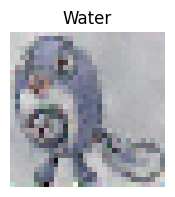

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 685ms/step - loss: 0.0657
Epoch 51/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 0.0472
Epoch 52/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step - loss: 0.0879
Epoch 53/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 0.2178
Epoch 54/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 0.0985
Epoch 55/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 0.1037
Epoch 56/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 0.0722
Epoch 57/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - loss: 0.1262
Epoch 58/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 0.0910
Epoch 59/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - loss: 0.0650
Epoch 60/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.1088Epoch 60: Generating samples.
Generating sample 1/1


Sampling sprite: 150it [00:06, 23.43it/s]                         


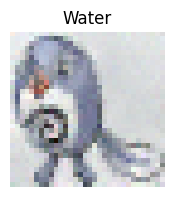

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 699ms/step - loss: 0.1024
Epoch 61/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - loss: 0.0510
Epoch 62/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - loss: 0.1073
Epoch 63/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - loss: 0.1136
Epoch 64/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 0.0672
Epoch 65/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - loss: 0.0762
Epoch 66/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - loss: 0.0730
Epoch 67/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - loss: 0.0419
Epoch 68/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - loss: 0.0961
Epoch 69/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - loss: 0.1507
Epoch 70/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.0662Epoch 70: Generating samples.
Generating sample 1/1


Sampling sprite: 150it [00:06, 23.29it/s]                         


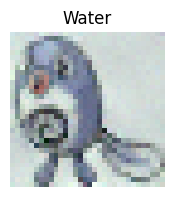

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 693ms/step - loss: 0.0623
Epoch 71/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 0.1696
Epoch 72/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - loss: 0.1053
Epoch 73/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 0.0632
Epoch 74/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 0.1263
Epoch 75/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - loss: 0.1424
Epoch 76/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - loss: 0.0566
Epoch 77/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - loss: 0.1208
Epoch 78/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - loss: 0.0616
Epoch 79/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - loss: 0.1415
Epoch 80/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.0851Epoch 80: Generating samples.
Generating sample 1/1


Sampling sprite: 150it [00:06, 23.18it/s]                         


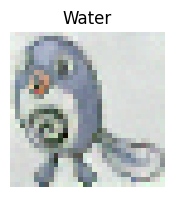

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 698ms/step - loss: 0.0801
Epoch 81/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - loss: 0.1565
Epoch 82/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - loss: 0.0456
Epoch 83/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - loss: 0.1224
Epoch 84/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - loss: 0.0720
Epoch 85/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 0.0855
Epoch 86/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 0.0749
Epoch 87/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 0.0888
Epoch 88/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - loss: 0.0715
Epoch 89/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - loss: 0.1239
Epoch 90/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.1005Epoch 90: Generating samples.
Generating sample 1/1


Sampling sprite: 150it [00:05, 26.40it/s]                         


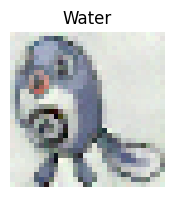

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 624ms/step - loss: 0.0946
Epoch 91/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 0.0461
Epoch 92/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.0610
Epoch 93/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.0388
Epoch 94/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - loss: 0.1551
Epoch 95/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - loss: 0.1728
Epoch 96/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - loss: 0.0934
Epoch 97/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 0.2185
Epoch 98/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - loss: 0.0604
Epoch 99/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - loss: 0.0909
Epoch 100/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0955Epoch 100: Generating samples.
Generating sample 1/1


Sampling sprite: 150it [00:05, 25.29it/s]                         


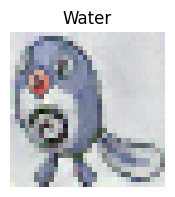

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 653ms/step - loss: 0.0898


In [10]:
tf.config.run_functions_eagerly(True)  # to debug the model
# model.fit(
#     dataset_example,
#     epochs=EPOCHS,
#     callbacks=[PlottingCallback(model, 6), DiffusionCallback(model, 20, "Electric")],
# )
str_label_example = onehot_to_string(label_example)
model.fit(
    dataset_example,
    epochs=EPOCHS,
    callbacks=[DiffusionCallback(model, 10, str_label_example)],
)

Generating sample 1/1


Sampling sprite: 150it [00:06, 24.83it/s]                         


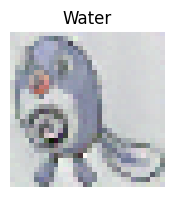

In [11]:
model.plot_samples(1, str_label_example)

Generating sample 1/3


Sampling sprite: 150it [00:06, 24.49it/s]                         


Generating sample 2/3


Sampling sprite: 150it [00:06, 24.94it/s]                         


Generating sample 3/3


Sampling sprite: 150it [00:05, 25.48it/s]                         


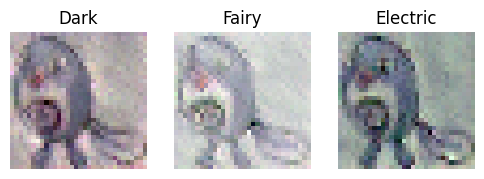

In [12]:
model.plot_samples(3)